In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import DirectoryIterator
from typing import Tuple
import cv2
import os

Connecting to google drive to download the dataset

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset link: https://drive.google.com/file/d/18bOmJEePjJOPKiWBdeuWq-8v-HwDSjbn/view

In [18]:
import os
import zipfile
#unzip heb letter zip file to tmp directory
local_zip = '/content/drive/MyDrive/Fire-dataset-224.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/D-fire-split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Resize all the images from the base directory to 128X128  

In [19]:
def resize_all(base_dir, out_size=(128, 128)):
  for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            img = cv2.imread(image_path)
            if img is not None and img.shape[:2] != out_size:
                img_resized = cv2.resize(img, out_size)
                cv2.imwrite(image_path, img_resized)

In [20]:
resize_all(base_dir, (128, 128))

In [21]:
def generate_data(target_size: Tuple[int, int] = (128, 128), batch_size: int = 64) -> Tuple[DirectoryIterator, DirectoryIterator]:
    """
    Generate data generators for training and validation datasets.

    Args:
        target_size (tuple): Target size for image resizing (default: (128, 128)).
        batch_size (int): Batch size for data generators (default: 64).

    Returns:
        Tuple[DirectoryIterator, DirectoryIterator]: A tuple containing the training and validation data generators.
    """
    train_datagen = ImageDataGenerator(rescale=1. / 255) #, zoom_range=0.1, brightness_range=[0.8, 1.2]) #, width_shift_range=0.15, height_shift_range=0.15,)
    val_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'  # Change to 'binary' for binary classification
    )
    validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'  # Change to 'binary' for binary classification
    )
    return train_generator, validation_generator

In [32]:
def create_model(input_shape=(128, 128, 3)) -> Sequential:
    """
    Create and return a convolutional neural network model.
     Args:
        input_shape (tuple): Input dataset shape (default: (128, 128, 3)).
    Returns:
        Sequential: The created model.
    """
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [23]:
def compile_model(model: Sequential, lr: float = 3e-4):
    """
    Compile the given model with a specified learning rate.

    Args:
        model (Sequential): The model to be compiled.
        lr (float): Learning rate for the optimizer.
    """
    opt = Adam(learning_rate=lr)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])
    return model

In [24]:
def check_point(acc_threshold: float, loss_threshold: float, path_to_acc: str, path_to_loss: str) -> Tuple[ModelCheckpoint, ModelCheckpoint]:
    """
    Create two ModelCheckpoint callbacks for monitoring validation accuracy and loss.

    Args:
        acc_threshold (float): Minimum improvement in accuracy to save the model.
        loss_threshold (float): Minimum improvement in loss to save the model.
        path_to_acc (str): File path for saving the model based on accuracy.
        path_to_loss (str): File path for saving the model based on loss.

    Returns:
        Tuple[ModelCheckpoint, ModelCheckpoint]: A tuple containing ModelCheckpoint callbacks for accuracy and loss.
    """
    mc_acc = ModelCheckpoint(f'{path_to_acc}_acc.h5', monitor='val_acc', initial_value_threshold=acc_threshold,
                             mode='max', verbose=1, save_best_only=True)
    mc_loss = ModelCheckpoint(f'{path_to_loss}_loss.h5', monitor='val_loss', initial_value_threshold=loss_threshold,
                              mode='min', verbose=1, save_best_only=True)
    return mc_acc, mc_loss


In [25]:
def load_model(model: Sequential, path_to_model: str):
    """
    Load model weights from a specified file.
    Args:
        model (Sequential): The model to load weights into.
        path_to_model (str): File path to the model weights.
    Return:
      the loaded model
    """
    model.load_weights(path_to_model)
    return model

In [26]:
def train_model(model: Sequential, train_generator: DirectoryIterator, validation_generator: DirectoryIterator, epochs: int, mc_acc: ModelCheckpoint, mc_loss: ModelCheckpoint, shuffle):
    """
    Train the model using the provided data generators and callbacks.

    Args:
        model (Sequential): The model to be trained.
        train_generator (DirectoryIterator): Data generator for training data.
        validation_generator (DirectoryIterator): Data generator for validation data.
        epochs (int): Number of training epochs.
        mc_acc (ModelCheckpoint): Callback for saving the model based on accuracy.
        mc_loss (ModelCheckpoint): Callback for saving the model based on loss.

    Returns:
        History: The training history.
    """
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        verbose=2,
        callbacks=[mc_acc, mc_loss],
        shuffle=shuffle,
    )
    return history


In [27]:
train_generator, validation_generator = generate_data(target_size=(128, 128))

Found 31091 images belonging to 2 classes.
Found 18693 images belonging to 2 classes.


In [36]:
model = create_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                                 
                                                      

In [37]:
mc_acc, mc_loss = check_point(0.8, 0.3, '/content/drive/MyDrive/save_model', '/content/drive/MyDrive/save_model')

In [38]:
model = compile_model(model, 3e-4)

Some running sample (not the final model)

In [39]:
history = train_model(model, train_generator, validation_generator, 20, mc_acc, mc_loss, shuffle=True)

Epoch 1/20

Epoch 1: val_acc did not improve from 0.80000

Epoch 1: val_loss did not improve from 0.30000
486/486 - 45s - loss: 0.4014 - acc: 0.8258 - val_loss: 0.6797 - val_acc: 0.7337 - 45s/epoch - 92ms/step
Epoch 2/20

Epoch 2: val_acc improved from 0.80000 to 0.84160, saving model to /content/drive/MyDrive/save_model_acc.h5

Epoch 2: val_loss did not improve from 0.30000
486/486 - 46s - loss: 0.2844 - acc: 0.8847 - val_loss: 0.4750 - val_acc: 0.8416 - 46s/epoch - 95ms/step
Epoch 3/20

Epoch 3: val_acc did not improve from 0.84160

Epoch 3: val_loss did not improve from 0.30000
486/486 - 39s - loss: 0.2358 - acc: 0.9077 - val_loss: 0.4235 - val_acc: 0.8338 - 39s/epoch - 80ms/step
Epoch 4/20

Epoch 4: val_acc improved from 0.84160 to 0.86546, saving model to /content/drive/MyDrive/save_model_acc.h5

Epoch 4: val_loss did not improve from 0.30000
486/486 - 41s - loss: 0.2006 - acc: 0.9219 - val_loss: 0.4278 - val_acc: 0.8655 - 41s/epoch - 84ms/step
Epoch 5/20

Epoch 5: val_acc improve

accuracy and loss plot

Text(0.5, 1.0, 'Training and validation loss')

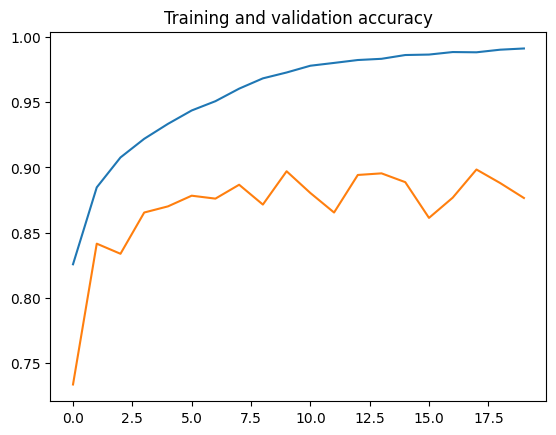

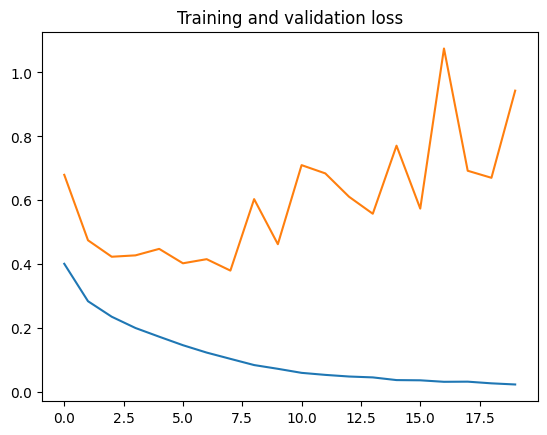

In [40]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

load the best model

In [ ]:
model = load_model(model, '/content/drive/MyDrive/mp_update_acc.h5')

save if needed

In [ ]:
model.save('temp.h5')

Image of the model

In [41]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/mp_update_acc.h5')

In [45]:
model.evaluate(train_generator)

486/486 [==============================] - 24s 50ms/step - loss: 9.9472e-04 - acc: 1.0000


[0.0009947221260517836, 1.0]

In [44]:
model.evaluate(validation_generator)

293/293 [==============================] - 14s 48ms/step - loss: 0.3078 - acc: 0.9358


[0.30780744552612305, 0.9357513785362244]

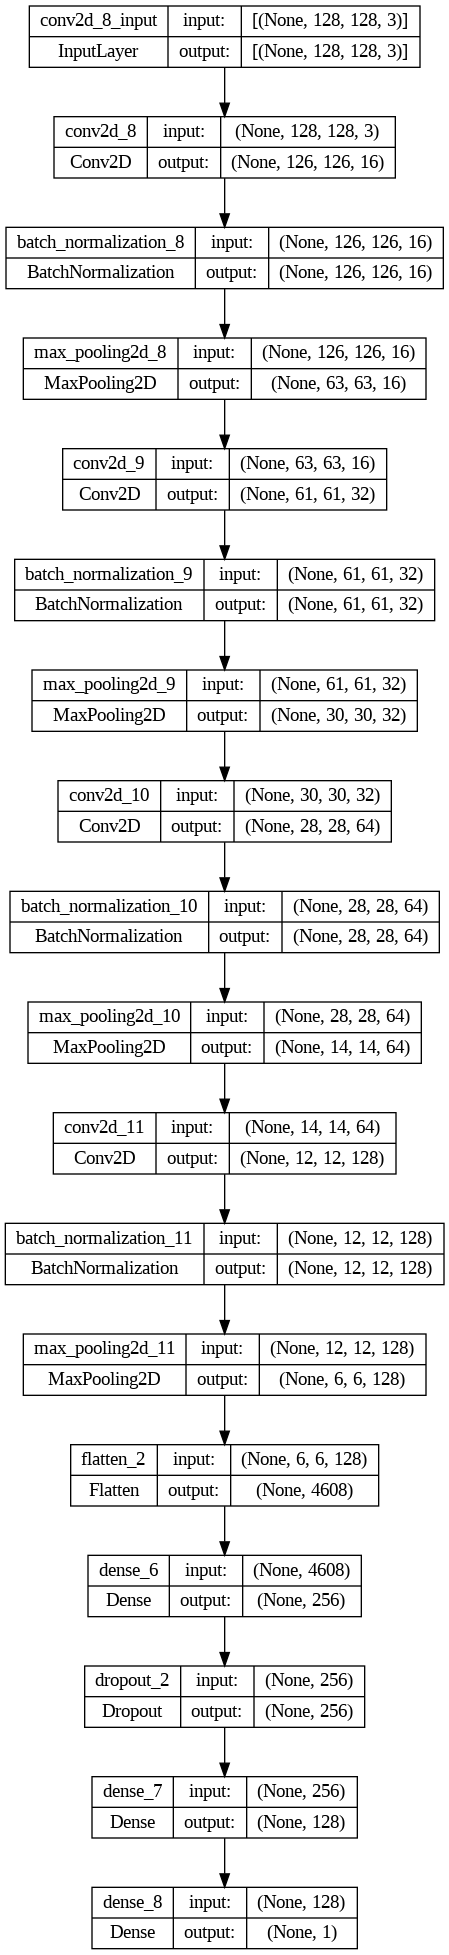

In [42]:
from keras.utils import plot_model

# Save a visualization of the model's architecture to a file
plot_model(model, to_file='model.png', show_shapes=True)

In [17]:
import cv2
import numpy as np

def resize_and_pad_image_cv2(image, output_size):
    """
    Resize an image to the specified size while maintaining its original aspect ratio.
    If necessary, pad the image to achieve the exact size.

    Args:
        image_path (str): Path to the input image.
        output_size (tuple): A tuple (width, height) specifying the desired output size (e.g., (224, 224)).

    Returns:
        np.ndarray: The resized and padded image as a NumPy array.
    """

    # Calculate the aspect ratio
    original_height, original_width, _ = image.shape
    target_width, target_height = output_size
    aspect_ratio = original_width / original_height

    # Calculate the new dimensions while maintaining the aspect ratio
    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image using OpenCV's resize function
    resized_img = cv2.resize(image, (new_width, new_height))

    # Create a new blank image with the target size
    padded_img = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    # Calculate the position to paste the resized image in the center
    left = (target_width - new_width) // 2
    upper = (target_height - new_height) // 2
    right = left + new_width
    lower = upper + new_height

    # Paste the resized image into the center of the new image
    padded_img[upper:lower, left:right] = resized_img

    return padded_img


In [50]:
def predict_image(image: np.ndarray, model: tf.keras.Model):
    desired_shape = (128, 128)
    resized_image = cv2.resize(image, desired_shape)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    plt.imshow(resized_image)
    preprocessed_image = resized_image.astype('float32') / 255.0
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    predictions = model(preprocessed_image)
    return predictions

In [ ]:
img = cv2.imread('/content/drive/MyDrive/screentest2.jpg')
img = resize_and_pad_image_cv2(img, (128, 128))
res = predict_image(img,  model)

In [63]:
res.numpy()[0][0]

0.9998326